<a href="https://colab.research.google.com/github/ruslanchainik/pythonLabworks/blob/master/%D0%B2%D1%82%D0%BE%D1%80%D0%BE%D0%B9_%D1%81%D0%B5%D0%BC_%D0%BB%D0%B0%D0%B1%D0%B0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[('2017-12-01T00', 254, -5.2, 37., 2.2, 2000, -17.6, 0., 0, 1, 0)
 ('2017-12-01T01', 204, -5.5, 38., 0.8, 2000, -17.6, 0., 0, 1, 0)
 ('2017-12-01T02', 173, -6. , 39., 1. , 2000, -17.7, 0., 0, 1, 0) ...
 ('2018-11-30T21', 694,  2.6, 39., 0.3, 1968,  -9.9, 0., 0, 1, 3)
 ('2018-11-30T22', 712,  2.1, 41., 1. , 1859,  -9.8, 0., 0, 1, 3)
 ('2018-11-30T23', 584,  1.9, 43., 1.3, 1909,  -9.3, 0., 0, 1, 3)]


/tmp/ipython-input-27-2125353846.py:228: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', k)


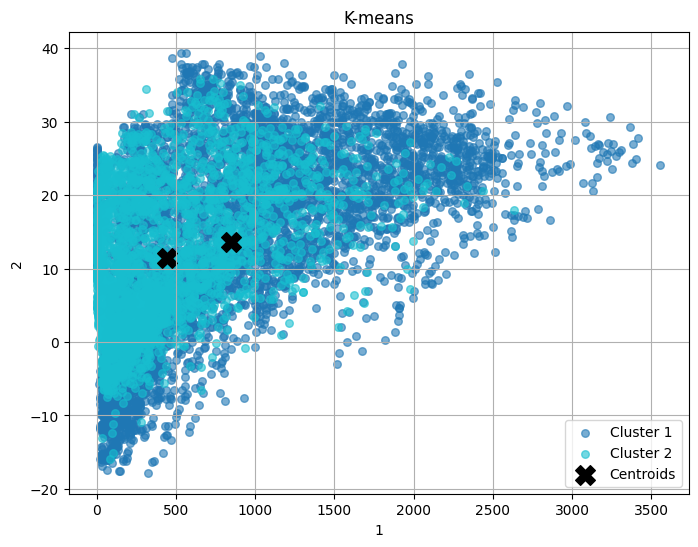

-0.6640189960567345


In [27]:
import numpy as np
import matplotlib.pyplot as plt  #все нужные импорты для работы
from google.colab import drive
import scipy
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

drive.mount('/content/drive')
data = np.genfromtxt('/content/drive/MyDrive/content/SeoulBikeData.csv',
                     delimiter=',',
                     dtype=None,
                     encoding='latin1',
                     names=True)   # genfromtxt позволяет считать цсвшку так же как pd.read_csv только с помощью нампая
season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}

date_arr = np.array(data['Date'])

rented_bike_count_arr = np.array(data['Rented'])

hour_arr = np.array(data['Hour'])

temperature_arr = np.array(data['Temperature'])

humidity_arr = np.array(data['Humidity'])

wind_speed_arr = np.array(data['Wind'])

visibility_arr = np.array(data['Visibility']) #были изменены имена в исходном файле для упрощения обращения к получившемуся структурированному массиву

dew_point_arr = np.array(data['Dew'])

solar_radiation_arr = np.array(data['Solar'])

rainfall_arr = np.array(data['Rainfall'])

snowfall_arr = np.array(data['Snowfall'])

seasons_arr = np.array(data['Seasons'])
seasons_encoded = np.array([season_mapping[season] for season in seasons_arr])
holiday_arr = np.array(data['Holiday'])

functioning_day_arr = np.array(data['Functioning'])

#print(set(functioning_day_arr))  проверка есть ли вообще в этой колонке значения NO

functioning_day_arr = np.where(functioning_day_arr == "Yes", 1, 0) #кодирование бинарного признака

holiday_arr = np.where(holiday_arr == "Holiday", 1, 0)

matrics_rth = np.column_stack((rented_bike_count_arr,
                              hour_arr,
                              temperature_arr,
                              humidity_arr,
                              wind_speed_arr))   #создадим матрицу, которая на первый взгляд содержит вполне коррелирующие параметры для дальнейшей работы





def true_date(elem):
    parts = elem.split('/')
    parts = parts[::-1]
    return '-'.join(parts)

vectorized_true_date = np.vectorize(true_date)

true_date_arr = vectorized_true_date(date_arr)
hour_arr = hour_arr.astype(str)
hour_formatted = np.char.zfill(hour_arr, 2)
super_true_date = np.char.add(np.char.add(true_date_arr, "T"), hour_formatted)   #все эти строки просто для того чтобы сделать нормальную дату которую нампай понимает как дату
super_true_date = super_true_date.astype('datetime64[h]')


#print(len(super_true_date) == len(rented_bike_count_arr))  на всякий случай
new_data = np.array(
    list(zip(
        super_true_date,
        rented_bike_count_arr,
        temperature_arr,
        humidity_arr,
        wind_speed_arr,
        visibility_arr,
        dew_point_arr,
        solar_radiation_arr,
        holiday_arr,
        functioning_day_arr, seasons_encoded
    )),
    dtype=[
        ('date', 'datetime64[h]'),
        ('count', 'int64'),
        ('temperature', 'float64'),
        ('humidity', 'float64'),
        ('wind_speed', 'float64'),
        ('visibility', 'int64'),
        ('dew_point', 'float64'),
        ('solar_radiation', 'float64'),
        ('holiday', 'int64'),
        ('functioning_day', 'int64'), ('seasons', 'int64')         # датасет новый нормальный
    ]
)
print(new_data)
start_date = np.datetime64('2017-12-01')
end_date = np.datetime64('2017-12-31')
date_range_mask = (new_data['date'] >= start_date) & (new_data['date'] <= end_date)

date_range_data = new_data[date_range_mask] # срез на декабрь
day_date = np.datetime64('2017-12-07')
next_day = day_date + np.timedelta64(1, 'D')

date_one_day = new_data[(new_data['date'] >= day_date) & (new_data['date'] < next_day)]

# второй пункт II можно побаловаться и сделать исключающую дизьюнкицию
minus = functioning_day_arr - holiday_arr
# можно сделать dew point который уже есть в данных и сравнить

dew_point_arr2 = temperature_arr - (100 - humidity_arr)/ 5

#print(dew_point_arr2) чуток отличаются друг от друга (формула примерная взята из интернета)
#print(dew_point_arr)

dot_product = np.dot(temperature_arr, dew_point_arr)
def cosine(x, y):
  return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

#print(cosinus)
#print(dot_product)
# можно сделать вывод что вектора близки к друг другу cos -> 1 угол -> 0


def pearson(x, y):
  x_mean = np.mean(x)
  y_mean = np.mean(y)
  numerator = np.sum((x - x_mean) * (y - y_mean))
  denominator = np.sqrt(np.sum((x - x_mean) ** 2)) * np.sqrt(np.sum((y - y_mean) ** 2))
  return numerator / denominator

#print(pearson(temperature_arr, dew_point_arr))
#print(np.corrcoef(temperature_arr, dew_point_arr))  #сравним


def normalize(x):
  norm = np.linalg.norm(x)
  return x / norm

#print(1 - scipy.spatial.distance.cosine(normalize(temperature_arr), normalize(dew_point_arr)))  тоже сравним
#print(cosine(normalize(temperature_arr), normalize(dew_point_arr)))


def find_similar_days(day, period, k=5):
    # Вытаскиваем фичи текущего дня, исключая поле 'date'
    day_features = np.stack([day[name] for name in day.dtype.names if name != 'date']).flatten()
    norm_day = normalize(day_features).reshape(1, -1)

    num_days = len(period) // 24
    date_list = []
    feature_matrix = []

    for i in range(num_days):
        day_i_struct = period[i*24:(i+1)*24]
        day_i_features = np.stack([day_i_struct[name] for name in day_i_struct.dtype.names if name != 'date']).flatten()
        norm_day_i = normalize(day_i_features)
        feature_matrix.append(norm_day_i)

        raw_date = day_i_struct[0]['date']
        date_str = str(raw_date).split('T')[0]
        date_list.append(date_str)

    feature_matrix = np.array(feature_matrix)
    sims = cosine_similarity(norm_day, feature_matrix)[0]
    top_indices = np.argsort(sims)[::-1][:k]

    top_dates = [date_list[i] for i in top_indices]
    top_scores = sims[top_indices]

    return top_dates



#print(find_similar_days(date_one_day, date_range_data))


for_time_series1 = np.datetime64('2017-12-09T13')
for_time_series2 = np.datetime64('2017-12-10T13')

mask = (new_data['date'] >= for_time_series1) & (new_data['date'] <= for_time_series2)
time_series_data = new_data[mask]
kernel = np.array([1/7]*7)
temperature_data = time_series_data['temperature']

smoothed = np.convolve(temperature_data, kernel, mode='same')
def gaussian_kernel(size, sigma):

    center = (size - 1) / 2
    x = np.arange(size)

    kernel = np.exp(-0.5 * ((x - center) / sigma) ** 2)

    kernel /= kernel.sum()
    return kernel
kernel1 = gaussian_kernel(7, 1)
smoothed1 = np.convolve(temperature_data, kernel1, mode='same')
#plt.plot(temperature_data, label='Original')
#plt.plot(smoothed1, label='Smoothed', linewidth=2)
#plt.legend()
#plt.grid()
#plt.show()


#k-means


def k_means(data, k, max_iterations=100):
    num_points, num_features = data.shape
    centroids = data[np.random.choice(num_points, k, replace=False)]
    for _ in range(max_iterations):
        distance = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distance, axis=1)
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return labels, centroids



def plot_k_means(data, labels, centroids):
    k = len(centroids)
    colors = plt.cm.get_cmap('tab10', k)

    plt.figure(figsize=(8,6))


    for i in range(k):
        cluster_points = data[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    s=30, color=colors(i), label=f'Cluster {i+1}', alpha=0.6)


    plt.scatter(centroids[:, 0], centroids[:, 1],
                s=200, color='black', marker='X', label='Centroids')

    plt.title('K-means')
    plt.xlabel('1')
    plt.ylabel('2')
    plt.legend()
    plt.grid(True)
    plt.show()


data_for_clustering = np.stack([new_data[name] for name in new_data.dtype.names if name != 'date'], axis=1)  #была ошибка т.к структурированный массив возвращал в функцию к средних только одно число, пришлос перепаять его в обычный массив
labels, centroids = k_means(data_for_clustering, 2)
plot_k_means(data_for_clustering, labels, centroids)    # взял две фичи температура и рентед наглядно видно что когда температура побольше байков берут побольше
# если брать больше двух кластеров для этих фич то они накладываются друг на друга и выводы делать тяжело

np.random.seed(42)

n = 20


temperature = np.random.normal(loc=-2, scale=3, size=n)


humidity = np.random.randint(20, 56, size=n)


wind = np.round(np.random.uniform(0.5, 4.5, size=n), 1)


visibility_values = np.array([2000, 1996, 1936, 1928, 793])
probabilities = np.array([0.7, 0.1, 0.1, 0.05, 0.05])
visibility = np.random.choice(visibility_values, size=n, p=probabilities)


random_data = np.column_stack((temperature, humidity, wind, visibility))


for_random_data1 = np.datetime64('2017-12-09T00')
for_random_data2 = np.datetime64('2017-12-09T19')
mask1 = (new_data['date'] >= for_random_data1) & (new_data['date'] <= for_random_data2)

compare_data = new_data[mask1]
data_for_compare = np.stack([compare_data[name] for name in compare_data.dtype.names if name in ['temperature', 'humidity', 'wind', 'visibility']], axis=1)

print(pearson(random_data[:, 0], data_for_compare[:, 0])) # данные по температуре коррелируют но делают это в обратную сторону то есть генеративные данные зеркально отражают тренд реальных